# Small project 1

Analyze data from an ASDEX Upgrade experiment: is the divertor neutral pressure dependant of gas fueling, heating power, both, neither?

## 1 - Import the needed data

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 10, 5

First let's import the Divertor Pressure file

In [3]:
pressure = np.loadtxt('pressure.30733')

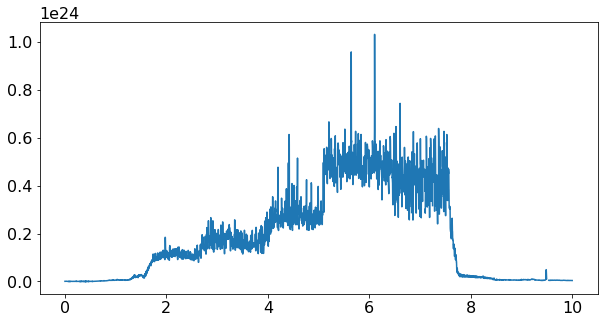

In [4]:
plt.plot(pressure[:,0], pressure[:,1])
plt.show()

In [5]:
#Check the time scale
print pressure[21,0], pressure[22,0]

0.0209360998124 0.0219360999763


In [6]:
def smooth(data, N=20):
    return np.convolve(data, np.ones(N)/float(N))[(N-1):]

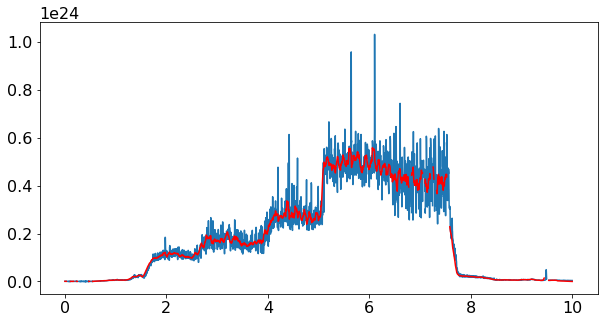

In [7]:
plt.plot(pressure[:,0], pressure[:,1])
plt.plot(pressure[:,0], smooth(pressure[:,1], 50), color='r')
plt.show()

In [8]:
smthpres = smooth(pressure[:,1], 50)

In [9]:
fuelling = np.loadtxt('fuel.30733')

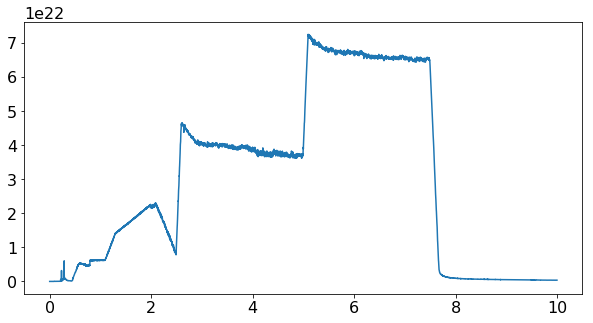

In [10]:
plt.plot(fuelling[:,0], fuelling[:,1])
plt.show()

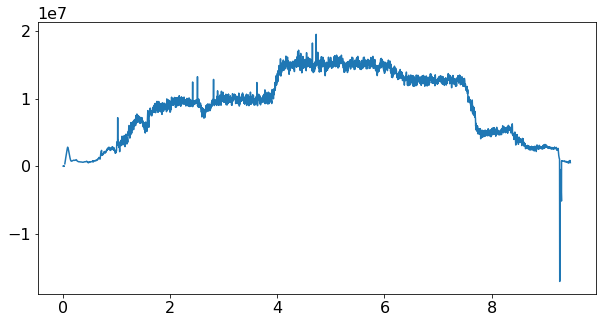

In [11]:
pheat = np.loadtxt('heating_power.30733')
plt.plot(pheat[:,0], pheat[:,1])
plt.show()

# 2 - Producing a DataFrame and cleaning up the data

In [12]:
import pandas as pd
from scipy.interpolate import interp1d

In [13]:
common_time = np.arange(1.5, 7.5, 0.01)

Interpolate data for the common time ranges.

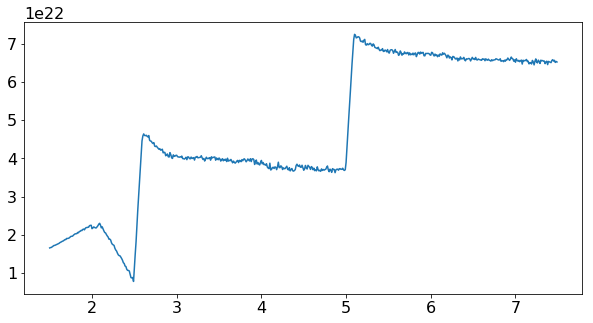

In [14]:
f_interp = interp1d(fuelling[:,0], fuelling[:,1])
new_fuel = f_interp(common_time)
plt.plot(common_time, new_fuel)
plt.show()

Repeat for Heating Power and divertor pressure.

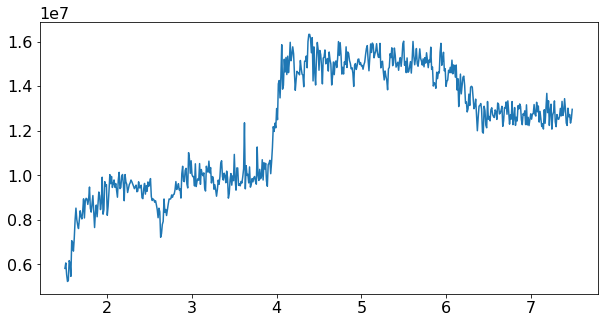

In [15]:
h_interp = interp1d(pheat[:,0], pheat[:,1])
new_power = h_interp(common_time)
plt.plot(common_time, new_power)
plt.show()

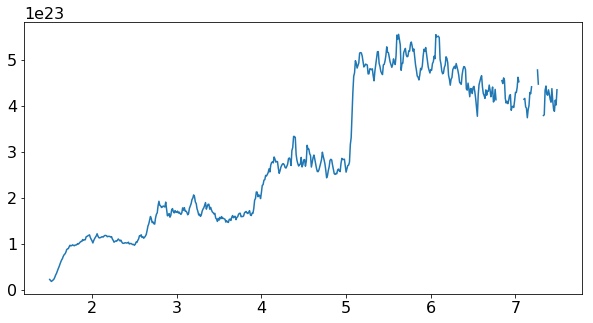

In [16]:
press_interp = interp1d(pressure[:,0], smthpres)
new_press = press_interp(common_time)
plt.plot(common_time, new_press)
plt.show()

Create the dataframe:

In [17]:
#Declare the name with unitsstrtime = 'Time [s]'
strTime = 'Time [s]'
strFuel = 'Fuelling [$10^{22}$e/s]'
strPow = 'Power [MW]'
strPres = 'Pressure [$10^{23}$e$m^{-2}$]'

In [18]:
#Pass a dictionary as input
d = {strTime: common_time,
     strFuel: new_fuel*1e-22,
     strPow: new_power*1e-6,
     strPres: new_press*1e-23}

In [19]:
df = pd.DataFrame(data=d)

In [20]:
df.head()

,Fuelling [$10^{22}$e/s],Power [MW],Pressure [$10^{23}$e$m^{-2}$],Time [s]
0,1.661650,5.821626,0.233784,1.50
1,1.670681,6.065982,0.211688,1.51
2,1.675284,5.544021,0.190404,1.52
3,1.692749,5.235031,0.204430,1.53
4,1.710480,5.271766,0.221030,1.54


Reorganize columnsn to have time as first column. This will become a feature in future python editions, so we will just circumvent this with a short workaround.

In [21]:
col_order = [strTime, strFuel, strPow, strPres]

In [22]:
df = df[col_order]

In [23]:
df.head()

,Time [s],Fuelling [$10^{22}$e/s],Power [MW],Pressure [$10^{23}$e$m^{-2}$]
0,1.50,1.661650,5.821626,0.233784
1,1.51,1.670681,6.065982,0.211688
2,1.52,1.675284,5.544021,0.190404
3,1.53,1.692749,5.235031,0.204430
4,1.54,1.710480,5.271766,0.221030


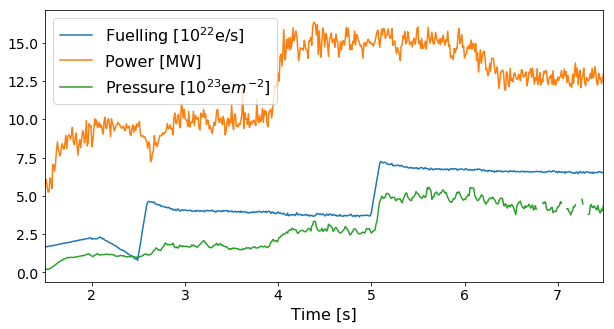

In [24]:
df.plot(kind='line', x=strTime, figsize=(10, 5), fontsize=14)
plt.show()

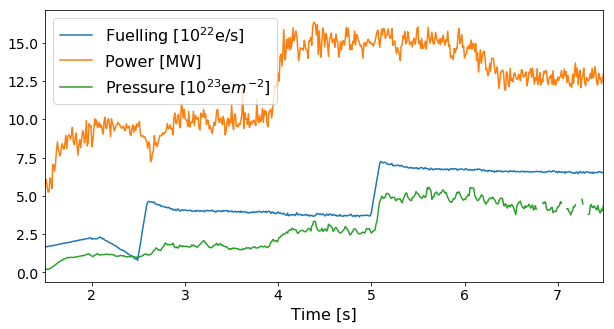

In [25]:
df.plot(kind='line', x=strTime, figsize=(10, 5), fontsize=14)
plt.show()

To finish cleaning up the data, we must clean out all NaNs, Infs and non-numerical values. We'll start by copying the dataframe into a new one.

In [26]:
ldf = df.copy(deep=True)

In [27]:
ldf.dropna(axis=0, inplace=True)

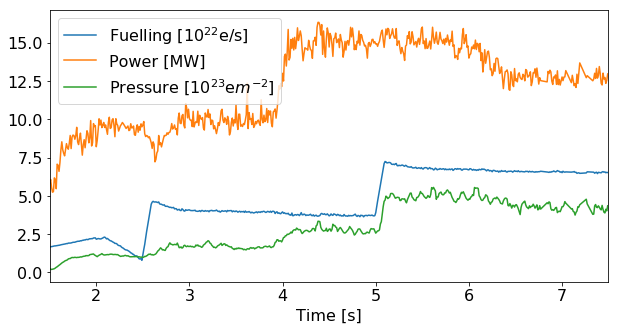

In [28]:
ldf.plot(kind='line', x=strTime, figsize=(10,5))
plt.show()

## 3 - Model and fitting

$$Pressure = k \times Fuel^{A}\times Pheat^{B}$$
becomes:
$$\log{Pressure} = k' + A \log{Fuel} + B \log{Pheat}$$
Convert to logarithm, but first make a copy of the DataFrame.

In [29]:
ldf.head()

,Time [s],Fuelling [$10^{22}$e/s],Power [MW],Pressure [$10^{23}$e$m^{-2}$]
0,1.50,1.661650,5.821626,0.233784
1,1.51,1.670681,6.065982,0.211688
2,1.52,1.675284,5.544021,0.190404
3,1.53,1.692749,5.235031,0.204430
4,1.54,1.710480,5.271766,0.221030


In [30]:
ldf[strPow] = np.log(ldf[strPow])
ldf[strFuel] = np.log(ldf[strFuel])
ldf[strPres] = np.log(ldf[strPres])

In [31]:
ldf.head()

,Time [s],Fuelling [$10^{22}$e/s],Power [MW],Pressure [$10^{23}$e$m^{-2}$]
0,1.50,0.507811,1.761580,-1.453357
1,1.51,0.513232,1.802696,-1.552641
2,1.52,0.515983,1.712720,-1.658609
3,1.53,0.526354,1.655373,-1.587531
4,1.54,0.536774,1.662365,-1.509459


Now we'll define a fitting function.

In [32]:
#Define a fitting function
def fit_func( (lfuel, lheat), k, a, b):
    return k + a*lfuel + b*lheat

In [33]:
from scipy.optimize import *

In [34]:
popt, pcov = curve_fit(fit_func, (ldf[strFuel], ldf[strPow]), ldf[strPres])

In [35]:
#The optimised parameters of the fit
print "popt:", popt
#One standard deviation errors on the parameters.
perr = np.sqrt(np.diag(pcov))
print "perr:", perr
#The covariance matrix of the parameters
print "pcov:", pcov

popt: [-3.79767075  0.71382085  1.47907766]
perr: [ 0.08426096  0.01967226  0.04025949]
pcov: [[ 0.00709991  0.00071824 -0.00326838]
 [ 0.00071824  0.000387   -0.00051469]
 [-0.00326838 -0.00051469  0.00162083]]


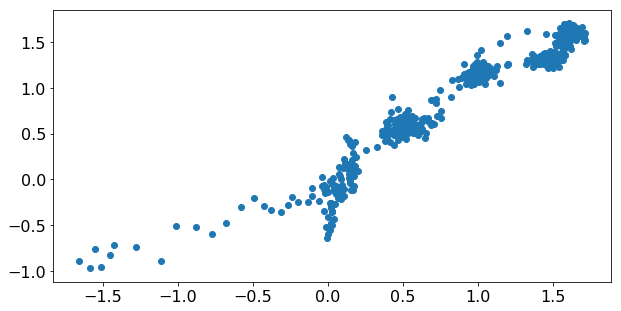

In [36]:
plt.scatter(ldf[strPres], fit_func( (ldf[strFuel], ldf[strPow]), *popt))
plt.show()

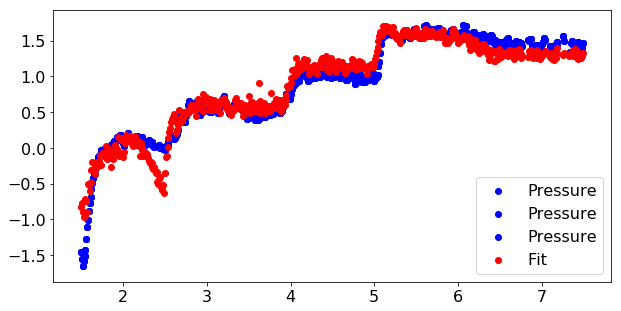

In [41]:
plt.scatter(ldf[strTime], ldf[strPres], label='Pressure', color='blue')
plt.scatter(ldf[strTime], fit_func( (ldf[strFuel], ldf[strPow]), *popt), label='Fit', color='red')
plt.legend()
plt.show()